# Test notebook for functional regression

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale


import skfda
from skfda.ml.regression import KNeighborsRegressor
from skfda.representation.basis import FourierBasis

from skfda.representation.grid import FDataGrid


## Files Reading

In [2]:
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')

ds = ds.isel(time_counter = (np.arange(0, len(ds.time_counter),2)), 
    y=(np.arange(ds.y[0], ds.y[-1], 5)), 
    x=(np.arange(ds.x[0], ds.x[-1], 5)))

ds2 = ds2.isel(time_counter = (np.arange(0, len(ds2.time_counter),2)), 
    y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
    x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))
dataset2 = ds2.sel(time_counter = slice('2007', '2020'))


## Datasets Preparation

In [3]:
test = np.stack([np.reshape(np.ravel(dataset['Temperature_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Temperature_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Salinity_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Salinity_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Summation_of_solar_radiation']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Mean_wind_speed']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Mean_air_temperature']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    ])

x =  np.tile(dataset.x, len(dataset.y))
y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

indx = np.where((~np.isnan(test[1]).any(axis=0)) & (x>10) & ((x>100) | (y<880)))
test = test[:,:,indx[0]]

test = np.transpose(test,axes=(0,2,1))

test[0] = minmax_scale(test[0])
test[1] = minmax_scale(test[1])
test[2] = minmax_scale(test[2])
test[3] = minmax_scale(test[3])
test[4] = minmax_scale(test[4])
test[5] = minmax_scale(test[5])
test[6] = minmax_scale(test[6])

test2 = np.reshape(np.ravel(dataset['Diatom']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))
test2 = test2[:,indx[0]]
test2 = test2.transpose()
# test2 = minmax_scale(test2)


In [19]:
test2.shape

(1838, 527)

In [4]:
# test1 = np.reshape(np.ravel(dataset['Flagellate']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))
# test2 = np.reshape(np.ravel(dataset['Diatom']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))

# x =  np.tile(dataset.x, len(dataset.y))
# y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

# indx = np.where((~np.isnan(test2).any(axis=0)) & (x>10) & ((x>100) | (y<880)))

# test1 = test1[:,indx[0]]
# test2 = test2[:,indx[0]]

# test1 = test1.transpose()
# test2 = test2.transpose()

# # test1 = minmax_scale(test1)
# # test2 = minmax_scale(test2)


In [5]:
input = np.transpose(test,axes=(1,2,0))
input = FDataGrid(input, np.arange(0,len(dataset.time_counter)))
target = FDataGrid(test2, np.arange(0,len(dataset.time_counter)))
target = target.to_basis(FourierBasis(n_basis=5))


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    input,
    target,
    test_size=0.3)

## Training 

In [7]:
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

KNeighborsRegressor(weights='distance')

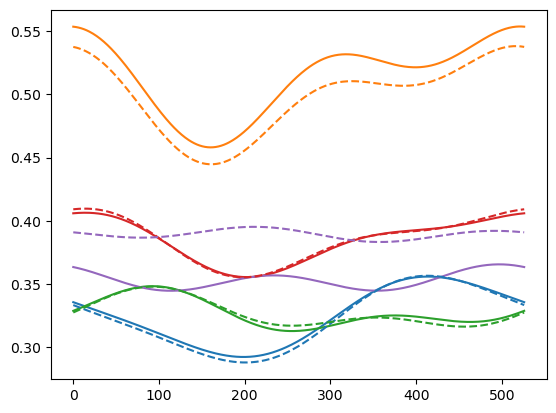

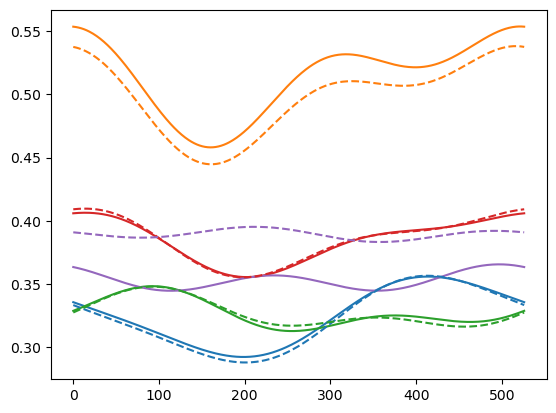

In [8]:
y_pred = knn.predict(X_test)
# Plot prediction
fig = y_pred[0:5].plot()

fig.axes[0].set_prop_cycle(None)  # Reset colors
y_test[0:5].plot(fig=fig, linestyle='--')

In [9]:
score = knn.score(X_test, y_test)
print(score)

0.9126674513240018


In [10]:
b = np.array(y_pred.to_grid().data_matrix.tolist())
b = np.squeeze(b,2)
b.shape

(552, 501)

In [11]:
a = np.array(y_test.to_grid().data_matrix.tolist())
a = np.squeeze(a,2)

In [12]:
np.corrcoef(np.ravel(a),np.ravel(b))[0][1]

0.9590687506450749